
# Loading the libraries

In [2]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [3]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
#print(x.shape,y.shape)

In [4]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [5]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [6]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Training software BP with new subsampled version of MNIST

In [7]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [8]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [9]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  # return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [10]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [11]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [12]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [13]:
def batch_grad_descent(X,Y,batchsize,iter, lr, midLayerSize, seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      train_loss.append(np.sum(crossEntropy(one_hot_encoding(Y), A2_train)))
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      val_loss.append(np.sum(crossEntropy(one_hot_encoding(y_val), A2_val)))
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [14]:
W1, b1, W2, b2, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,batchsize = 630,iter=100, lr=0.1,midLayerSize = 10, seed = 47,print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 65.67142857142856
Val accuracy: 64.47142857142858 Val loss: 6653.281599688319
Iteration: 2
Train accuracy: 69.95396825396826
Val accuracy: 69.19999999999999 Val loss: 5723.207730349599
Iteration: 3
Train accuracy: 71.65079365079366
Val accuracy: 71.14285714285714 Val loss: 5342.6829474595215
Iteration: 4
Train accuracy: 72.63809523809523
Val accuracy: 72.17142857142858 Val loss: 5110.70009579257
Iteration: 5
Train accuracy: 73.4904761904762
Val accuracy: 73.12857142857143 Val loss: 4928.86631570027
Iteration: 6
Train accuracy: 74.28095238095239
Val accuracy: 74.02857142857144 Val loss: 4764.495329503856
Iteration: 7
Train accuracy: 74.98412698412699
Val accuracy: 74.7 Val loss: 4633.007240898238
Iteration: 8
Train accuracy: 75.53650793650793
Val accuracy: 75.34285714285714 Val loss: 4518.873969677319
Iteration: 9
Train accuracy: 76.11904761904762
Val accuracy: 76.0 Val loss: 4412.086344467167
Iteration: 10
Train accuracy: 76.7
Val accurac

### Generic functions related to variability

In [15]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [16]:
def initMosParam(shape, mu, sigma, vDD, precision, asym, k=10000):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((mu - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((mu - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)

    if asym==0:
        Vth_asym = np.random.normal(loc = Vth, scale = 0)
    else :
        Vth_asym = np.random.normal(loc = Vth, scale = Vth*asym/100)
    Vth_asym[Vth_asym<=0] = 10e-10
    iOnAsym = I0On * np.exp((mu - Vth_asym)/(VT))
    iOnNominalAsym = np.sum(iOnAsym)/(dim1*dim2*precision)
    iOffAsym = I0Off * np.exp((mu - Vth_asym)/(VT))
    #return these
    return (iOn, iOnNominal, iOff), (iOnAsym, iOnNominalAsym, iOffAsym)

In [17]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [18]:
def batch_grad_descent_with_var(X,Y, batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1asym = W1.copy()
  b1asym = b1.copy()
  W2asym = W2.copy()
  b2asym = b2.copy()


  W1sym = W1.copy()
  b1sym = b1.copy()
  W2sym = W2.copy()
  b2sym = b2.copy()


  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents, W1CurrentsAsym = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, asym = asym, k =onoff)#k = Ion/Ioff
  b1Currents, b1CurrentsAsym = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, asym = asym,k =onoff)
  W2Currents, W2CurrentsAsym = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, asym = asym,k =onoff)
  b2Currents, b2CurrentsAsym = initMosParam((10, 1), mu, sigma, vDD, precision, asym = asym,k =onoff)




  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches #shd be 63000//batchsize
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batchsize = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
    
      


      #blind updates
      # W1varoc = weightTransformWithVariability(W1asym, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1asym, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2asym, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2asym, b2Currents, precision, step, discreteSteps, wRange)

      # W1varocAsym = weightTransformWithVariability(W1asym, W1CurrentsAsym, precision, step, discreteSteps, wRange)
      # b1varocAsym = weightTransformWithVariability(b1asym, b1CurrentsAsym, precision, step, discreteSteps, wRange)
      # W2varocAsym = weightTransformWithVariability(W2asym, W2CurrentsAsym, precision, step, discreteSteps, wRange)
      # b2varocAsym = weightTransformWithVariability(b2asym, b2CurrentsAsym, precision, step, discreteSteps, wRange)
      

      Z1, A11, Z2, A21 = forward(X1, W1asym, b1asym, W2asym, b2asym) 

      dW1asym, db1asym, dW2asym, db2asym = backprop(Z1, A11, Z2, A21, W1asym, W2asym, X1, Y1)

      W1asym, b1asym, W2asym, b2asym = param_update(W1asym, b1asym, W2asym,b2asym, dW1asym, db1asym, dW2asym, db2asym, lr = lr)

      # W1asym = roundArbitrary(W1asym, step, wRange)#weights have to maintained as their digitized versions
      # b1asym = roundArbitrary(b1asym, step, wRange)
      # W2asym = roundArbitrary(W2asym, step, wRange)
      # b2asym = roundArbitrary(b2asym, step, wRange)





      #Symmetrical circuit
      W1varoc = weightTransformWithVariability(W1sym, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1sym, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2sym, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2sym, b2Currents, precision, step, discreteSteps, wRange)
      # if(i==0 and (j==0 or j==1)):
      #   plt.figure()
      #   plt.plot(W1sym.flatten(), W1sym.flatten(), 'r.', label = "Soft")
      #   plt.plot(W1sym.flatten(), W1varoc.flatten(), 'b.',label = "var")
      #   plt.legend()

      Z1, A12, Z2, A22 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 
      # if(i==0 and (j==0 or j==1)):
      #   plt.figure()
      #   plt.plot(A21[:, 1], A21[:, 1], 'r.', label = "Soft")
      #   plt.plot(A21[:, 1], A22[:, 1], 'g.', label = "Var")
      #   plt.legend()

      dW1sym, db1sym, dW2sym, db2sym = backprop(Z1, A12, Z2, A22, W1varoc, W2varoc, X1, Y1)

      W1sym, b1sym, W2sym, b2sym = param_update(W1sym, b1sym, W2sym,b2sym, dW1sym, db1sym, dW2sym, db2sym, lr = lr)

      W1sym = roundArbitrary(W1sym, step, wRange)#weights have to maintained as their digitized versions
      b1sym = roundArbitrary(b1sym, step, wRange)
      W2sym = roundArbitrary(W2sym, step, wRange)
      b2sym = roundArbitrary(b2sym, step, wRange)

      # plt.figure()
      # plt.plot(dW1sym.flatten(), dW1asym.flatten(), '.', label = "Asymetry")
      # plt.plot(dW1sym.flatten(), dW1sym.flatten(), '.', alpha = 0.1,label = "OneOneline")
      # plt.legend()
      # if(i==0 and (j==0 or j==1)):
      #   plt.figure()
      #   plt.subplot(121)
      #   plt.plot(dW2asym.flatten(), dW2asym.flatten(), 'r.', label="Software")
      #   plt.plot(dW2asym.flatten(), dW2sym.flatten(), 'b.', label = "Var")
      #   plt.legend()
      #   plt.subplot(122)
      #   plt.plot(W1asym.flatten(), W1asym.flatten(), 'r.', label = "Software")
      #   plt.plot(W1asym.flatten(), W1sym.flatten(), 'b.', label = "Var")
      #   plt.legend()


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      # W1varoc = weightTransformWithVariability(W1asym, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1asym, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2asym, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2asym, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1asym, b1asym, W2asym, b2asym)
      _, _, _,   A2_val = forward(x_val, W1asym, b1asym, W2asym, b2asym)
      asymAccTrainAcc = accuracy(predictions(A2_train), Y)
      asymTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      asymAccValAcc = accuracy(predictions(A2_val), y_val)
      asymValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))



       #obtain training loss
      W1varoc = weightTransformWithVariability(W1sym, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1sym, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2sym, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2sym, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      symAccTrainAcc = accuracy(predictions(A2_train), Y)
      symTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      symAccValAcc = accuracy(predictions(A2_val), y_val)
      symValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


  
      train_acc.append([asymAccTrainAcc, symAccTrainAcc])
      train_loss.append([asymTrainLoss, symTrainLoss])
      print(f'Training :: Asym : {asymAccTrainAcc} :: Sym : {symAccTrainAcc}')


      val_acc.append([asymAccValAcc, symAccValAcc])
      val_loss.append([asymValLoss, symValLoss])
      print(f'Validation  :: Asym : {asymAccValAcc} :: Sym  : {symAccValAcc}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1asym, b1, W1sym, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [39]:
def batch_grad_descent_with_var_chipInLoop(X,Y, batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1symsoft = W1.copy()
  b1symsoft = b1.copy()
  W2symsoft = W2.copy()
  b2symsoft = b2.copy() #software copy of weights
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1asym = W1.copy()
  b1asym = b1.copy()
  W2asym = W2.copy()
  b2asym = b2.copy()


  W1sym = W1.copy()
  b1sym = b1.copy()
  W2sym = W2.copy()
  b2sym = b2.copy()

  
  


  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents, W1CurrentsAsym = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, asym = asym, k =onoff)#k = Ion/Ioff
  b1Currents, b1CurrentsAsym = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, asym = asym,k =onoff)
  W2Currents, W2CurrentsAsym = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, asym = asym,k =onoff)
  b2Currents, b2CurrentsAsym = initMosParam((10, 1), mu, sigma, vDD, precision, asym = asym,k =onoff)




  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches #shd be 63000//batchsize
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batchsize = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
    
      


      #blind updates
      W1varoc = weightTransformWithVariability(W1asym, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1asym, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2asym, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2asym, b2Currents, precision, step, discreteSteps, wRange)

      # W1varocAsym = weightTransformWithVariability(W1asym, W1CurrentsAsym, precision, step, discreteSteps, wRange)
      # b1varocAsym = weightTransformWithVariability(b1asym, b1CurrentsAsym, precision, step, discreteSteps, wRange)
      # W2varocAsym = weightTransformWithVariability(W2asym, W2CurrentsAsym, precision, step, discreteSteps, wRange)
      # b2varocAsym = weightTransformWithVariability(b2asym, b2CurrentsAsym, precision, step, discreteSteps, wRange)
      

      Z1, A11, Z2, A21 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1asym, db1asym, dW2asym, db2asym = backprop(Z1, A11, Z2, A21, W1varoc, W2varoc, X1, Y1)

      W1asym, b1asym, W2asym, b2asym = param_update(W1asym, b1asym, W2asym,b2asym, dW1asym, db1asym, dW2asym, db2asym, lr = lr)

      W1asym = roundArbitrary(W1asym, step, wRange)#weights have to maintained as their digitized versions
      b1asym = roundArbitrary(b1asym, step, wRange)
      W2asym = roundArbitrary(W2asym, step, wRange)
      b2asym = roundArbitrary(b2asym, step, wRange)





      #Symmetrical circuit
      W1varoc = weightTransformWithVariability(W1sym, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1sym, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2sym, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2sym, b2Currents, precision, step, discreteSteps, wRange)
      # if(i==0 and (j==0 or j==1)):
      #   plt.figure()
      #   plt.plot(W1sym.flatten(), W1sym.flatten(), 'r.', label = "Soft")
      #   plt.plot(W1sym.flatten(), W1varoc.flatten(), 'b.',label = "var")
      #   plt.legend()

      Z1, A12, Z2, A22 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 
      # if(i==0 and (j==0 or j==1)):
      #   plt.figure()
      #   plt.plot(A21[:, 1], A21[:, 1], 'r.', label = "Soft")
      #   plt.plot(A21[:, 1], A22[:, 1], 'g.', label = "Var")
      #   plt.legend()

      dW1sym, db1sym, dW2sym, db2sym = backprop(Z1, A12, Z2, A22, W1symsoft, W2symsoft, X1, Y1)

      W1symsoft, b1symsoft, W2symsoft, b2symsoft = param_update(W1symsoft, b1symsoft, W2symsoft,b2symsoft, dW1sym, db1sym, dW2sym, db2sym, lr = lr)

      W1sym = roundArbitrary(W1symsoft.copy(), step, wRange)#weights have to maintained as their digitized versions
      b1sym = roundArbitrary(b1symsoft.copy(), step, wRange)
      W2sym = roundArbitrary(W2symsoft.copy(), step, wRange)
      b2sym = roundArbitrary(b2symsoft.copy(), step, wRange)

      # plt.figure()
      # plt.plot(dW1sym.flatten(), dW1asym.flatten(), '.', label = "Asymetry")
      # plt.plot(dW1sym.flatten(), dW1sym.flatten(), '.', alpha = 0.1,label = "OneOneline")
      # plt.legend()
      # if(i==0 and (j==0 or j==1)):
      #   plt.figure()
      #   plt.subplot(121)
      #   plt.plot(dW2asym.flatten(), dW2asym.flatten(), 'r.', label="Software")
      #   plt.plot(dW2asym.flatten(), dW2sym.flatten(), 'b.', label = "Var")
      #   plt.legend()
      #   plt.subplot(122)
      #   plt.plot(W1asym.flatten(), W1asym.flatten(), 'r.', label = "Software")
      #   plt.plot(W1asym.flatten(), W1sym.flatten(), 'b.', label = "Var")
      #   plt.legend()


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1asym, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1asym, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2asym, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2asym, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      asymAccTrainAcc = accuracy(predictions(A2_train), Y)
      asymTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      asymAccValAcc = accuracy(predictions(A2_val), y_val)
      asymValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))



       #obtain training loss
      W1varoc = weightTransformWithVariability(W1sym, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1sym, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2sym, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2sym, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      symAccTrainAcc = accuracy(predictions(A2_train), Y)
      symTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      symAccValAcc = accuracy(predictions(A2_val), y_val)
      symValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


  
      train_acc.append([asymAccTrainAcc, symAccTrainAcc])
      train_loss.append([asymTrainLoss, symTrainLoss])
      print(f'Training :: Asym : {asymAccTrainAcc} :: Sym : {symAccTrainAcc}')


      val_acc.append([asymAccValAcc, symAccValAcc])
      val_loss.append([asymValLoss, symValLoss])
      print(f'Validation  :: Asym : {asymAccValAcc} :: Sym  : {symAccValAcc}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1asym, b1, W1sym, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [40]:
mu = 0.7
sigma = 20e-3
onoff = 10000
asym = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 2
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10 #10
lr = 0.1 #0.1
batchsize = 630
newShape = x_train[:, 0].shape[0]

In [45]:
trainPlease = []
valPlease = []
Sig = 10**(-1*np.array([ 1.1, 1.2, 1.3, 1.4, 1.5, 2, 2.5]))
for sigma in Sig:
    W1, b1, W2, b2, train_acc_quant, val_acc_quant, train_loss_comp, val_loss_comp, sum_weights = batch_grad_descent_with_var(x_train,y_train,batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff,seed = 47,print_op=1)
    trainPlease.append(train_acc_quant)
    valPlease.append(val_acc_quant)

Params Initialised
Iteration: 1
Training :: Asym : 65.68730158730159 :: Sym : 23.814285714285717
Validation  :: Asym : 64.55714285714286 :: Sym  : 24.02857142857143
Iteration: 2
Training :: Asym : 69.96984126984127 :: Sym : 28.925396825396827
Validation  :: Asym : 69.21428571428572 :: Sym  : 29.4
Iteration: 3
Training :: Asym : 71.64126984126983 :: Sym : 29.165079365079364
Validation  :: Asym : 71.24285714285715 :: Sym  : 29.614285714285714
Iteration: 4
Training :: Asym : 72.64285714285714 :: Sym : 29.677777777777774
Validation  :: Asym : 72.14285714285714 :: Sym  : 29.45714285714286
Iteration: 5
Training :: Asym : 73.4904761904762 :: Sym : 24.44761904761905
Validation  :: Asym : 73.08571428571429 :: Sym  : 25.285714285714285
Iteration: 6
Training :: Asym : 74.28253968253968 :: Sym : 25.123809523809527
Validation  :: Asym : 73.97142857142858 :: Sym  : 26.314285714285713
Iteration: 7
Training :: Asym : 74.9968253968254 :: Sym : 18.249206349206347
Validation  :: Asym : 74.65714285714286 

In [41]:
trainCILFull = []
valCILFull = []
trainOCFull = []
valOCFull = []
Sig = 10**(-1*np.arange(1, 4, 0.2))
seeding = [2, 5, 32, 23, 47]
for index in range(0, 5):
    trainPleaseCILtemp = []
    valPleaseCILtemp = []
    trainPleaseOCtemp = []
    valPleaseOCtemp = []
    for sigma in Sig:
        W1, b1, W2, b2, train_acc_quant, val_acc_quant, train_loss_comp, val_loss_comp, sum_weights = batch_grad_descent_with_var_chipInLoop(x_train,y_train,batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff,seed = seeding[index],print_op=1)
        trainPleaseCILtemp.append(train_acc_quant[-1][1])
        valPleaseCILtemp.append(val_acc_quant[-1][1])
        trainPleaseOCtemp.append(train_acc_quant[-1][0])
        valPleaseOCtemp.append(val_acc_quant[-1][0])
    trainCILFull.append(trainPleaseCILtemp)
    valCILFull.append(valPleaseCILtemp)
    trainOCFull.append(trainPleaseOCtemp)
    valOCFull.append(valPleaseOCtemp)

Params Initialised
Iteration: 1
Training :: Asym : 13.658730158730158 :: Sym : 17.892063492063492
Validation  :: Asym : 14.371428571428572 :: Sym  : 18.428571428571427
Iteration: 2
Training :: Asym : 14.212698412698414 :: Sym : 24.23968253968254
Validation  :: Asym : 13.885714285714284 :: Sym  : 24.47142857142857
Iteration: 3
Training :: Asym : 12.687301587301587 :: Sym : 21.506349206349206
Validation  :: Asym : 12.642857142857142 :: Sym  : 21.014285714285712
Iteration: 4
Training :: Asym : 17.312698412698413 :: Sym : 27.115873015873014
Validation  :: Asym : 17.142857142857142 :: Sym  : 27.21428571428571
Iteration: 5
Training :: Asym : 15.526984126984129 :: Sym : 24.00952380952381
Validation  :: Asym : 14.985714285714286 :: Sym  : 24.557142857142857
Iteration: 6
Training :: Asym : 15.911111111111111 :: Sym : 21.815873015873017
Validation  :: Asym : 15.728571428571428 :: Sym  : 21.042857142857144
Iteration: 7
Training :: Asym : 13.79047619047619 :: Sym : 25.433333333333337
Validation  :

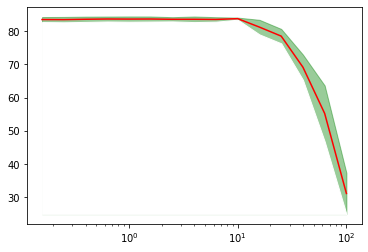

In [43]:
average = np.mean(np.array(trainOCFull), axis = 0)
std = np.std(np.array(trainOCFull), axis = 0)
plt.plot(Sig*1000, average, 'r')
plt.fill_between(Sig*1000, average+std, np.min(average-std), color = 'green',alpha = 0.4)
plt.fill_between(Sig*1000, average-std, np.min(average-std),color='white')
plt.xscale("log")

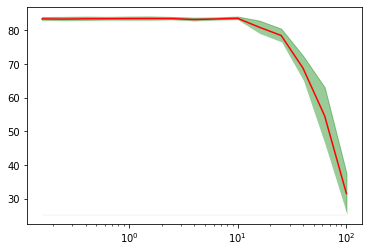

In [44]:
average = np.mean(np.array(valOCFull), axis = 0)
std = np.std(np.array(valOCFull), axis = 0)
plt.plot(Sig*1000, average, 'r')
plt.fill_between(Sig*1000, average+std, np.min(average-std), color = 'green',alpha = 0.4)
plt.fill_between(Sig*1000, average-std, np.min(average-std),color='white')
plt.xscale("log")

Params Initialised
Iteration: 1
Train accuracy: 51.72063492063492
Val accuracy: 51.300000000000004 Val loss: 8738.677722739514
Iteration: 2
Train accuracy: 62.50476190476191
Val accuracy: 62.07142857142857 Val loss: 7026.873047723312
Iteration: 3
Train accuracy: 66.10000000000001
Val accuracy: 66.27142857142857 Val loss: 6297.249320957806
Iteration: 4
Train accuracy: 68.20793650793651
Val accuracy: 68.34285714285714 Val loss: 5934.660105475683
Iteration: 5
Train accuracy: 69.9031746031746
Val accuracy: 69.8 Val loss: 5651.1827558208915
Iteration: 6
Train accuracy: 71.1936507936508
Val accuracy: 71.27142857142857 Val loss: 5383.57756438019
Iteration: 7
Train accuracy: 72.17619047619047
Val accuracy: 72.38571428571429 Val loss: 5173.544555167535
Iteration: 8
Train accuracy: 73.13174603174603
Val accuracy: 73.4 Val loss: 4982.137074792239
Iteration: 9
Train accuracy: 74.05396825396825
Val accuracy: 74.3 Val loss: 4806.877828685728
Iteration: 10
Train accuracy: 74.96825396825398
Val accura

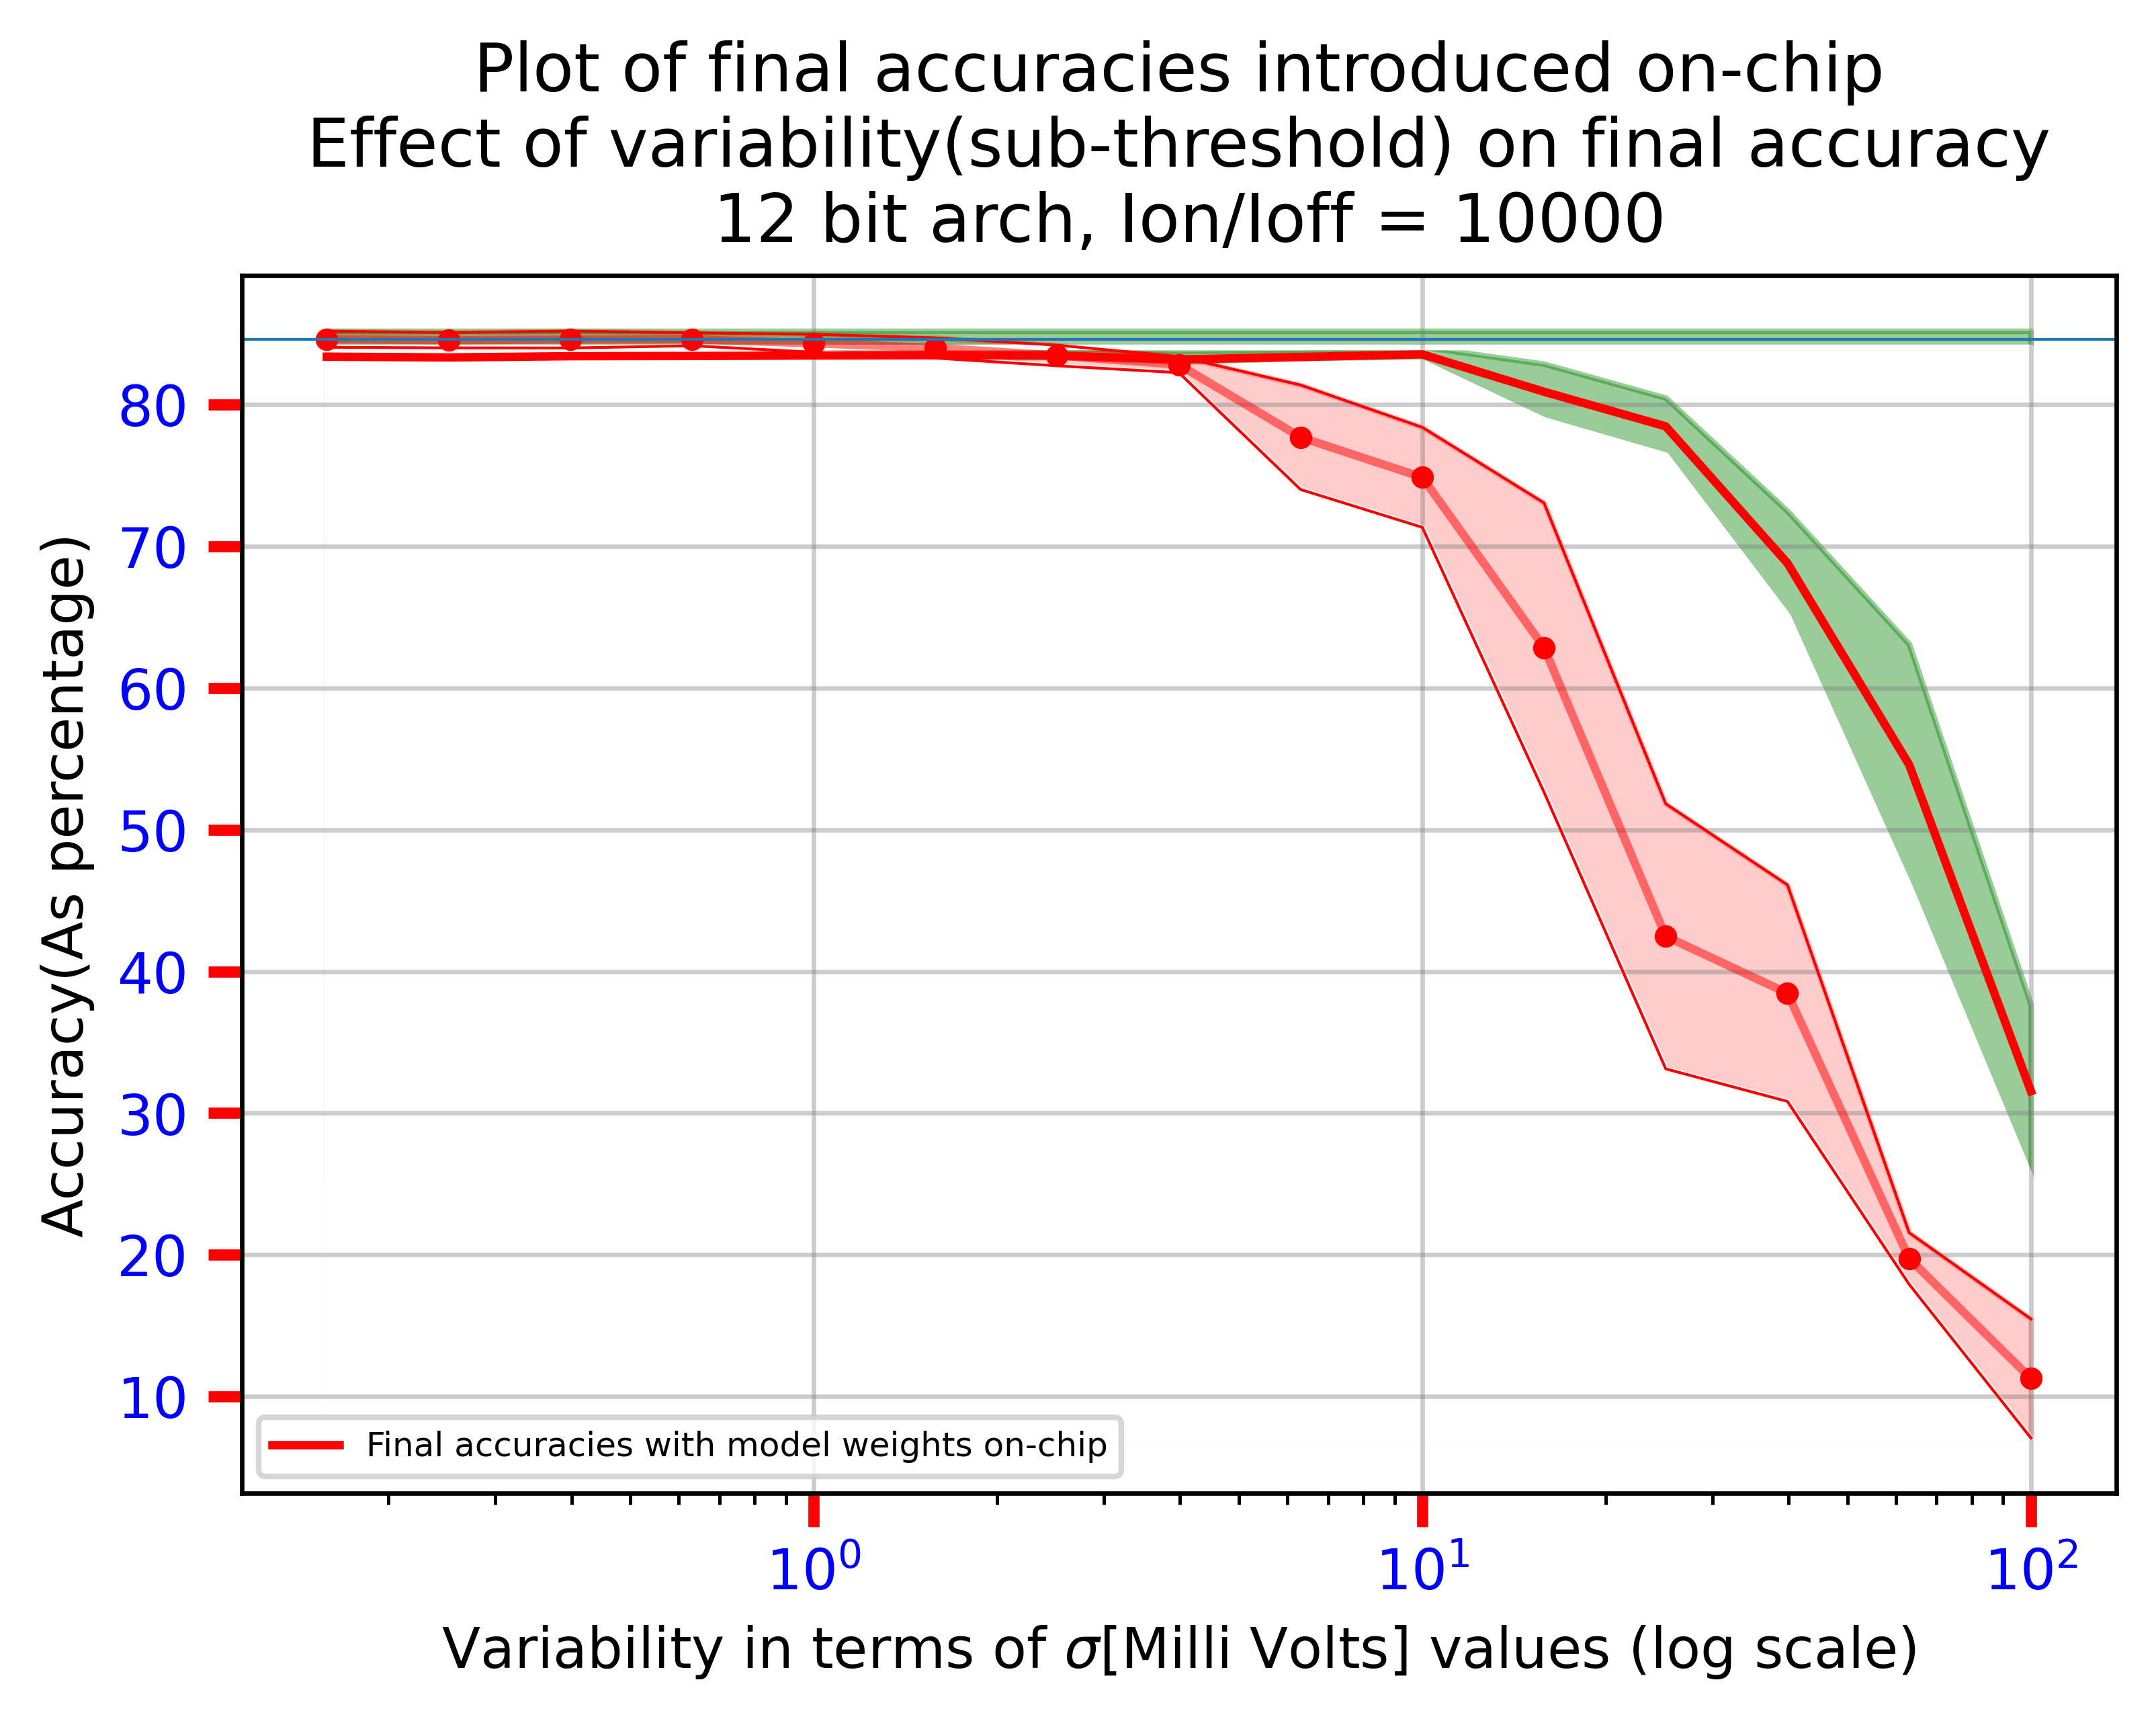

In [48]:
import matplotlib
matplotlib.rcParams["figure.dpi"] = 600
trainFullInf = []
trainAccBPStat = []
seeding = [2, 5, 32, 23, 47]
SigmaVal = 10**(-1*np.arange(1, 4, 0.2))
for index in range(0, 5):
    onlineTrainAcc = []
    onlineValAcc= []
    onlineTrainLoss = []
    onlineValLoss = []
    W1, b1, W2, b2, train_accBP, val_accBP, train_lossBP, val_lossBP, sum_weights = batch_grad_descent(x_train,y_train,batchsize = 630,iter=100, lr=0.1,midLayerSize = 10, seed = seeding[index],print_op=1);
    trainAccBPStat.append(val_accBP[-1])
    # onOffRatio = [1, 10, 100, 1000, 10000, 100000]
    # precisionVal = [4, 6, 8, 10, 12, 14, 16]
    for sigma in SigmaVal:
        W1Currents, _ = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, asym = 0,k =onoff)#k = Ion/Ioff
        b1Currents, _ = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, asym = 0,k =onoff)
        W2Currents, _ = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, asym = 0,k =onoff)
        b2Currents, _ = initMosParam((10, 1), mu, sigma, vDD, precision, asym = 0,k =onoff)
        W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps, wRange)
        b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps, wRange)
        W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps, wRange)
        b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps, wRange)
        _, _, _,  A2_train = forward(x_train, W1varoc, b1varoc, W2varoc, b2varoc)
        _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
        onlineTrainAcc.append(accuracy(predictions(A2_train), y_train))
        onlineTrainLoss.append(np.sum(crossEntropy(one_hot_encoding(y_train), A2_train)))
        onlineValAcc.append(accuracy(predictions(A2_val), y_val))
        onlineValLoss.append(np.sum(crossEntropy(one_hot_encoding(y_val), A2_val)))
    trainFullInf.append(onlineValAcc)
    # plt.plot(SigmaVal*1000, onlineTrainAcc, 'r.')
    # plt.plot(SigmaVal*1000, onlineTrainAcc, 'r', alpha = 0.2)

trainSTD = [np.std([trainFullInf[i][j] for i in range(0, 5)]) for j in range(0, len(SigmaVal))]
trainavg = [np.mean([trainFullInf[i][j] for i in range(0, 5)]) for j in range(0, len(SigmaVal))]
# trainHigh = [max([trainFullInf[i][j] for i in range(0, 5)]) for j in range(0, len(SigmaVal))]
# trainLow = [min([trainFullInf[i][j] for i in range(0, 5)]) for j in range(0, len(SigmaVal))]
trainHigh = np.array(trainavg)+np.array(trainSTD)
trainLow = np.array(trainavg)-np.array(trainSTD)

average = np.mean(np.array(valOCFull), axis = 0)
std = np.std(np.array(valOCFull), axis = 0)
plt.plot(Sig*1000, average, 'r')
plt.fill_between(Sig*1000, average+std, np.min(average-std), color = 'green',alpha = 0.4)
plt.fill_between(Sig*1000, average-std, np.min(average-std),color='white')

plt.plot(SigmaVal*1000, trainHigh, 'r', linewidth = 0.5)
plt.plot(SigmaVal*1000, trainLow, 'r', linewidth = 0.5)
plt.fill_between(SigmaVal*1000, trainHigh, np.min(trainLow), color = 'red',alpha = 0.2)
plt.fill_between(SigmaVal*1000, trainLow, np.min(trainLow),color='white')
plt.plot(SigmaVal*1000, trainavg, 'r.')
plt.plot(SigmaVal*1000, trainavg, 'r', alpha = 0.5)
plt.axhline(np.mean(trainAccBPStat), linewidth = 0.5, label = "Accuracy of model in software")
plt.fill_between(SigmaVal*1000, np.mean(trainAccBPStat)+np.std(trainAccBPStat), np.min(np.mean(trainAccBPStat) - np.std(trainAccBPStat)), color = 'green',alpha = 0.4)
plt.fill_between(SigmaVal*1000, np.mean(trainAccBPStat) - np.std(trainAccBPStat), np.min(np.mean(trainAccBPStat) - np.std(trainAccBPStat)),color='white')

plt.xscale("log")
plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='b', colors='r', grid_color='gray', grid_alpha=0.4)
plt.grid()
plt.xlabel(r"Variability in terms of $\sigma$[Milli Volts] values (log scale)")
plt.ylabel("Accuracy(As percentage)")
plt.title(f"Plot of final accuracies introduced on-chip\n Effect of variability(sub-threshold) on final accuracy \n 12 bit arch, Ion/Ioff = {onoff}")
plt.legend(["Final accuracies with model weights on-chip"], fontsize = 6)

In [24]:
W1, b1, W2, b2, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,batchsize = 630,iter=100, lr=0.1,midLayerSize = 10, seed = 2,print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 51.72063492063492
Val accuracy: 51.300000000000004 Val loss: 8738.677722739514
Iteration: 2
Train accuracy: 62.50476190476191
Val accuracy: 62.07142857142857 Val loss: 7026.873047723312
Iteration: 3
Train accuracy: 66.10000000000001
Val accuracy: 66.27142857142857 Val loss: 6297.249320957806
Iteration: 4
Train accuracy: 68.20793650793651
Val accuracy: 68.34285714285714 Val loss: 5934.660105475683
Iteration: 5
Train accuracy: 69.9031746031746
Val accuracy: 69.8 Val loss: 5651.1827558208915
Iteration: 6
Train accuracy: 71.1936507936508
Val accuracy: 71.27142857142857 Val loss: 5383.57756438019
Iteration: 7
Train accuracy: 72.17619047619047
Val accuracy: 72.38571428571429 Val loss: 5173.544555167535
Iteration: 8
Train accuracy: 73.13174603174603
Val accuracy: 73.4 Val loss: 4982.137074792239
Iteration: 9
Train accuracy: 74.05396825396825
Val accuracy: 74.3 Val loss: 4806.877828685728
Iteration: 10
Train accuracy: 74.96825396825398
Val accura

In [47]:
onlineTrainAcc = []
onlineValAcc= []
onlineTrainLoss = []
onlineValLoss = []
for sigma in Sig:
    W1Currents, _ = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, asym=0, k =onoff)#k = Ion/Ioff
    b1Currents, _ = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, asym=0,k =onoff)
    W2Currents, _ = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, asym=0,k =onoff)
    b2Currents, _ = initMosParam((10, 1), mu, sigma, vDD, precision, asym=0,k =onoff)
    W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps, wRange)
    b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps, wRange)
    W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps, wRange)
    b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps, wRange)
    _, _, _,  A2_train = forward(x_train, W1varoc, b1varoc, W2varoc, b2varoc)
    _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
    onlineTrainAcc.append(accuracy(predictions(A2_train), y_train))
    onlineTrainLoss.append(np.sum(crossEntropy(one_hot_encoding(y_train), A2_train)))
    onlineValAcc.append(accuracy(predictions(A2_val), y_val))
    onlineValLoss.append(np.sum(crossEntropy(one_hot_encoding(y_val), A2_val)))


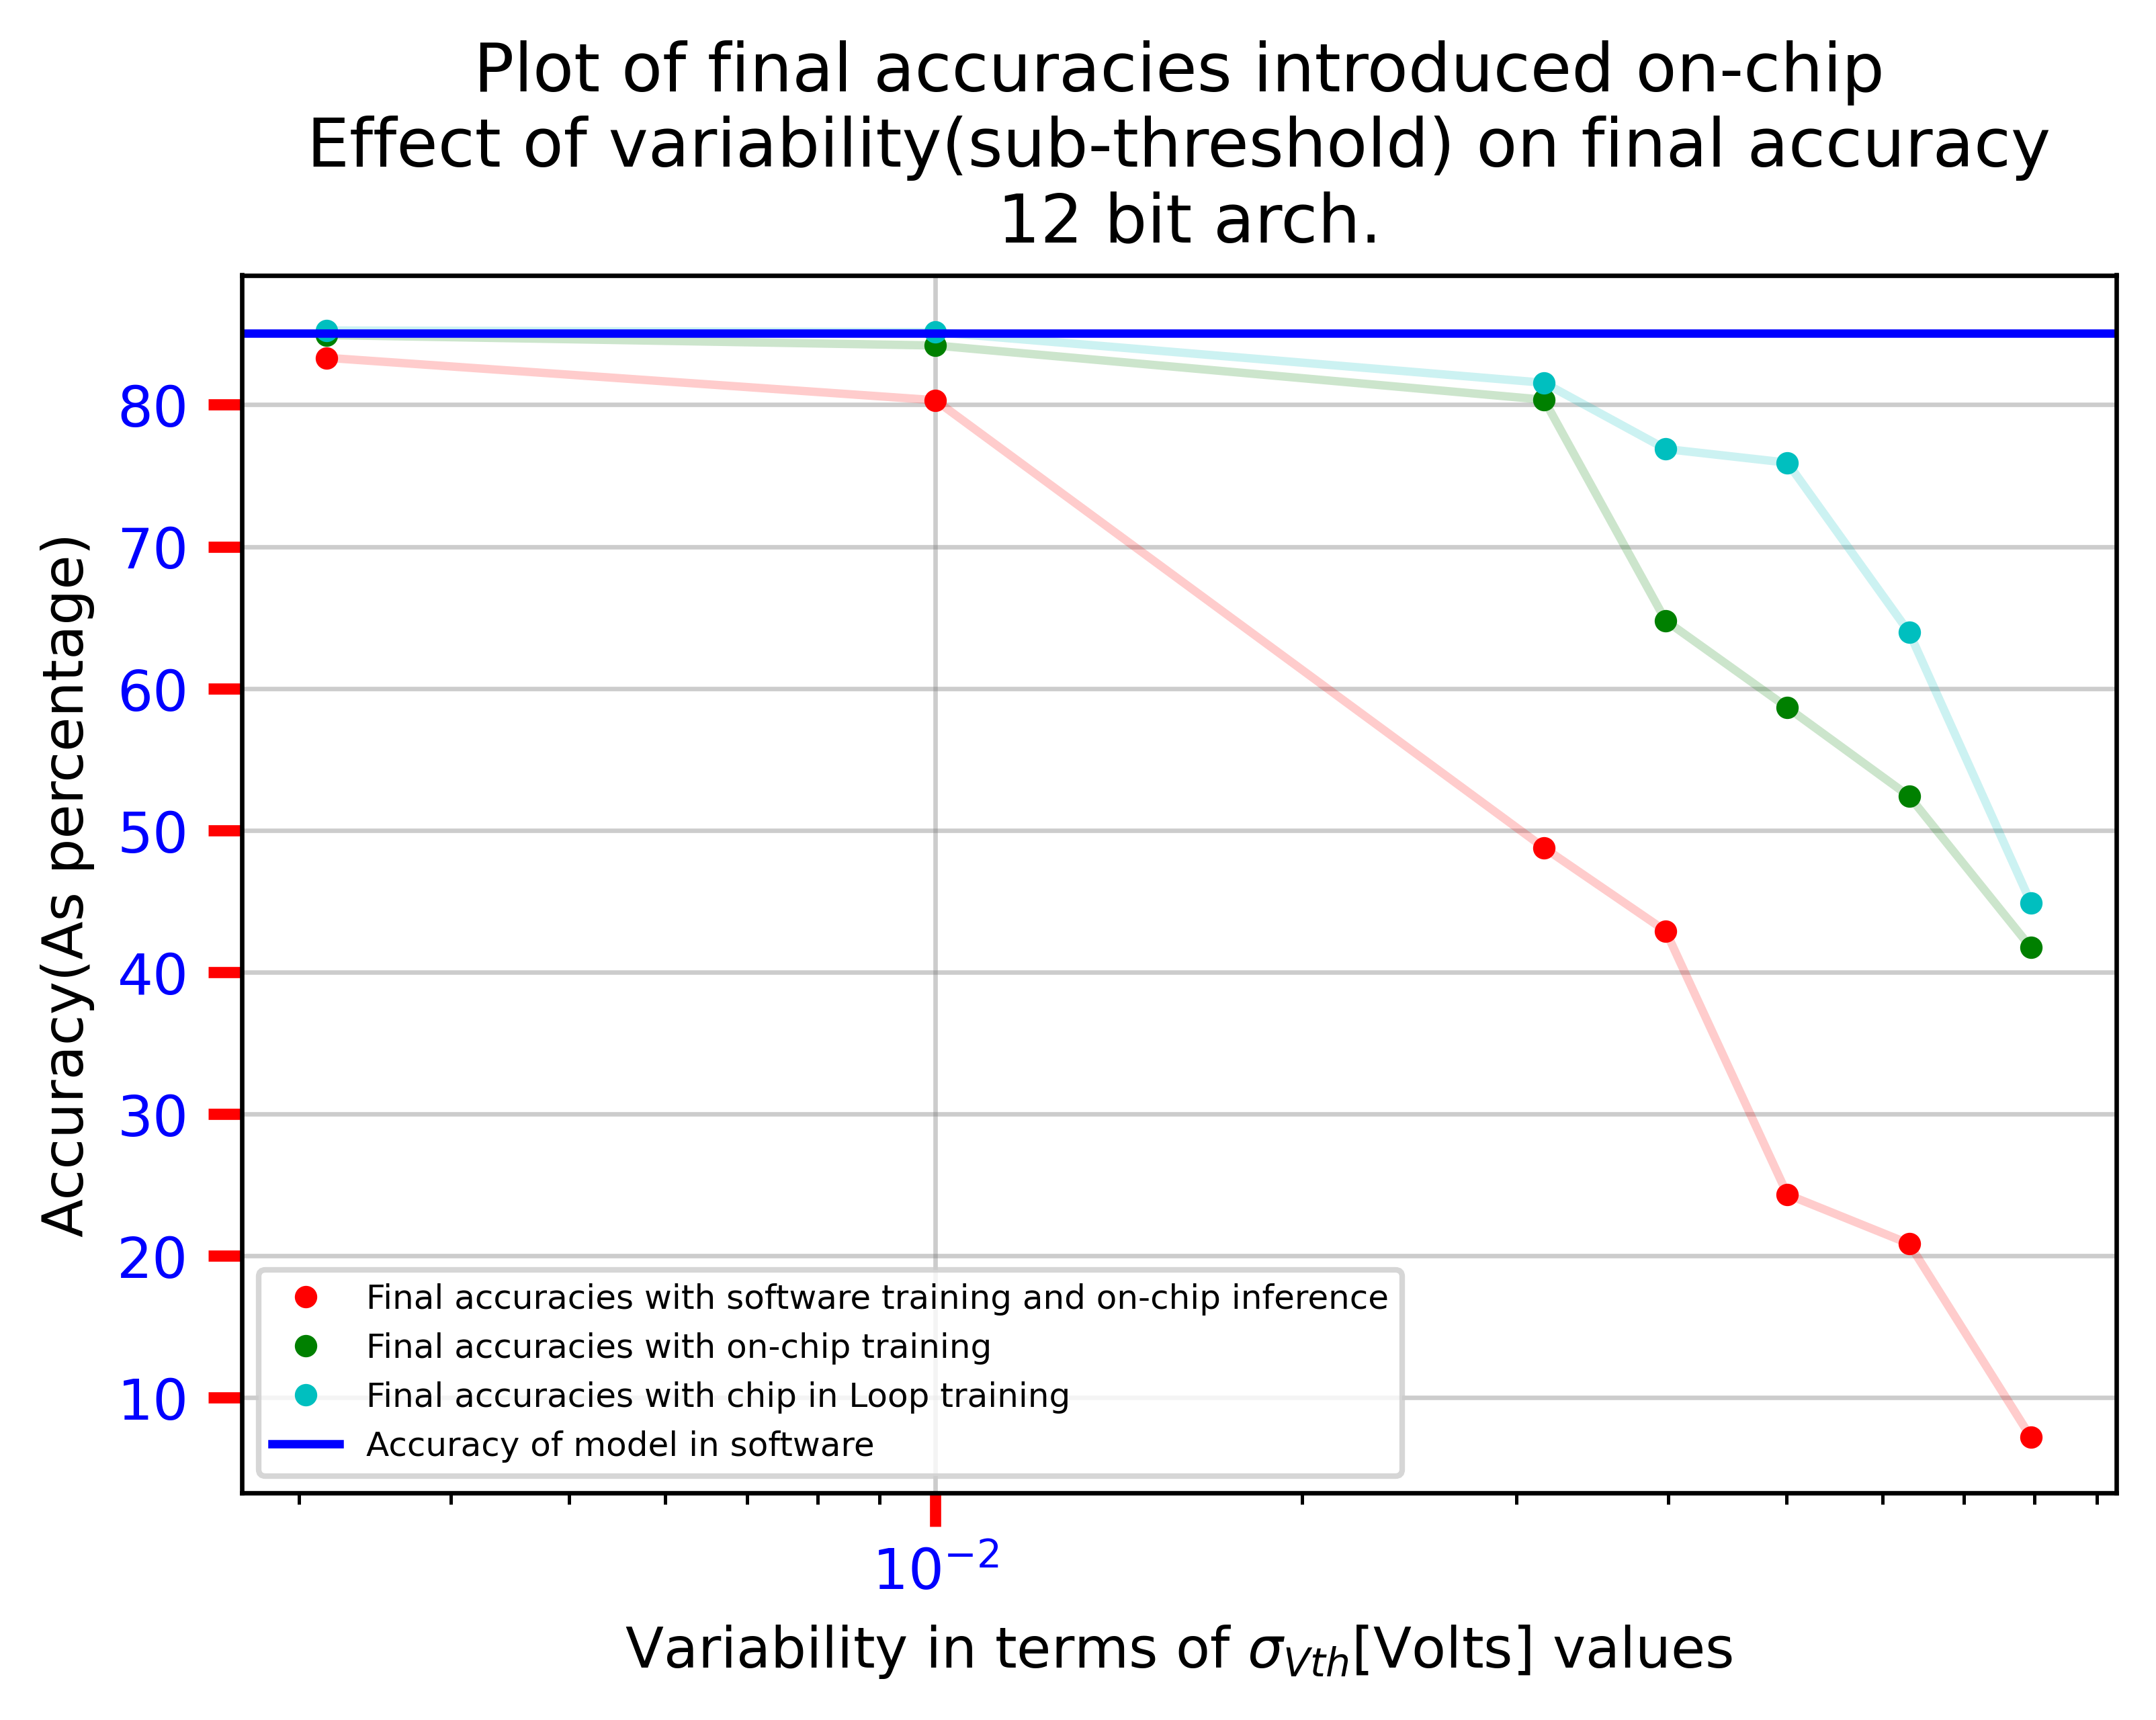

In [48]:
import matplotlib
matplotlib.rcParams["figure.dpi"] = 600
trainPleaseVarAdd = [trainPlease[i][-1][1] for i in range(0, len(Sig))]
trainPleaseVarAddCIL = [trainPleaseCIL[i][-1][1] for i in range(0, len(Sig))]
plt.plot(Sig, onlineTrainAcc, 'r.', label = "Final accuracies with software training and on-chip inference")
plt.plot(Sig, onlineTrainAcc, 'r', alpha = 0.2)
plt.plot(Sig, trainPleaseVarAdd, 'g.', label = "Final accuracies with on-chip training")
plt.plot(Sig, trainPleaseVarAdd, 'g', alpha = 0.2)
plt.plot(Sig, trainPleaseVarAddCIL, 'c.', label = "Final accuracies with chip in Loop training")
plt.plot(Sig, trainPleaseVarAddCIL, 'c', alpha = 0.2)
plt.axhline(train_accBP[-1], color = 'b', label = "Accuracy of model in software")
plt.xscale("log")
plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='b', colors='r', grid_color='gray', grid_alpha=0.4)
plt.grid()
plt.xlabel(r"Variability in terms of $\sigma_{Vth}$[Volts] values")
plt.ylabel("Accuracy(As percentage)")
plt.title("Plot of final accuracies introduced on-chip\n Effect of variability(sub-threshold) on final accuracy \n 12 bit arch.")
plt.legend(fontsize = 6)

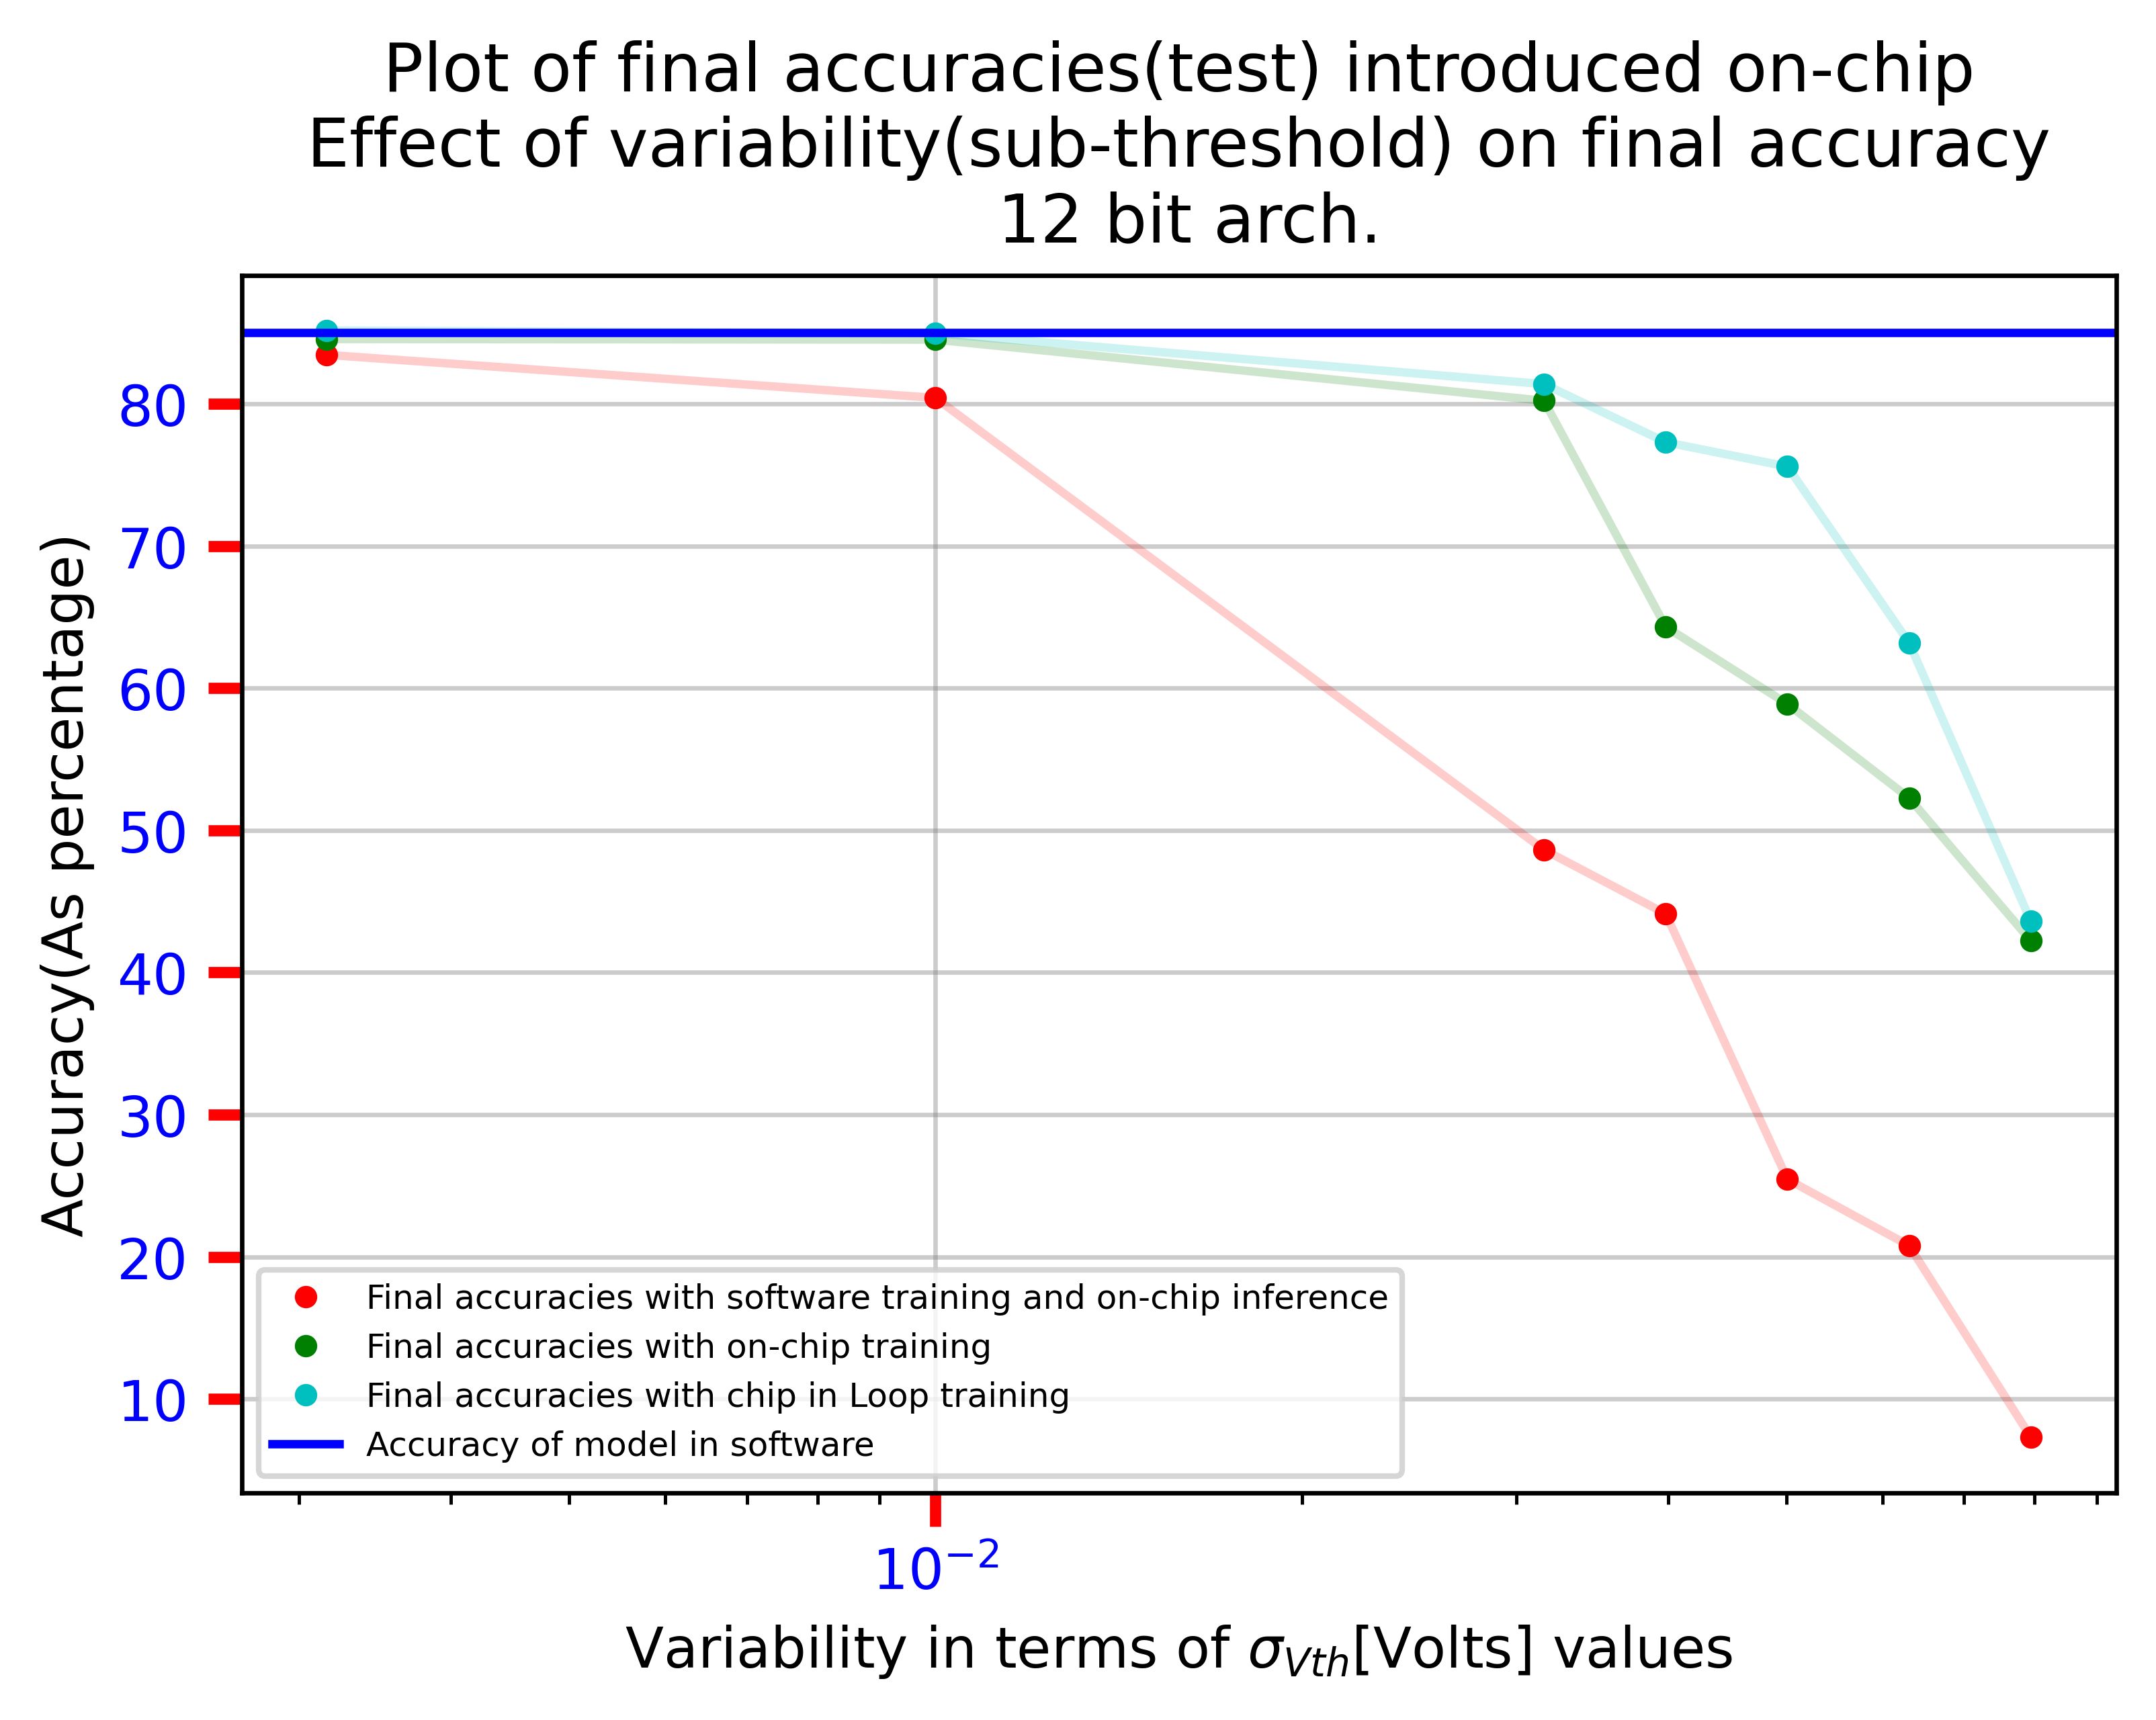

In [49]:
matplotlib.rcParams["figure.dpi"] = 600
valPleaseVarAdd = [valPlease[i][-1][1] for i in range(0, len(Sig))]
valPleaseVarAddCIL = [valPleaseCIL[i][-1][1] for i in range(0, len(Sig))]
plt.plot(Sig, onlineValAcc, 'r.', label = "Final accuracies with software training and on-chip inference")
plt.plot(Sig, onlineValAcc, 'r', alpha = 0.2)
plt.plot(Sig, valPleaseVarAdd, 'g.', label = "Final accuracies with on-chip training")
plt.plot(Sig, valPleaseVarAdd, 'g', alpha = 0.2)
plt.plot(Sig, valPleaseVarAddCIL, 'c.', label = "Final accuracies with chip in Loop training")
plt.plot(Sig, valPleaseVarAddCIL, 'c', alpha = 0.2)
plt.axhline(train_accBP[-1], color = 'b', label = "Accuracy of model in software")
plt.xscale("log")
plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='b', colors='r', grid_color='gray', grid_alpha=0.4)
plt.grid()
plt.xlabel(r"Variability in terms of $\sigma_{Vth}$[Volts] values")
plt.ylabel("Accuracy(As percentage)")
plt.title("Plot of final accuracies(test) introduced on-chip\n Effect of variability(sub-threshold) on final accuracy \n 12 bit arch.")
plt.legend(fontsize = 6)